In [1]:
!pip install Metatrader5


In [127]:
import MetaTrader5 as mt5
import pandas as pd
from datetime import datetime, timedelta, timezone
import time
# from zoneinfo import ZoneInfo      # stdlib since Python 3.9

# ========== SETTINGS ========== #
SYMBOL = "US30"  # Adjust to your broker's symbol name if needed
MT5_PATH = r"C:\Program Files\MetaTrader 5 IC Markets Global\terminal64.exe"
TIMEFRAME = mt5.TIMEFRAME_M15
# CSV_FILE = r"C:\Users\FRED\Desktop\MSE Capstone Project Files\US30_M15_ICMarkets.csv"
# CSV_FILE = r"C:\Users\FRED\Desktop\MSE Capstone Project Files\US30_M15_FXCM.csv"
# BATCH_SIZE = 10000  # MT5 API max per call


# ========== MT5 INITIALIZATION FUNCTION ========== #

def initialize_mt5_and_symbol(symbol, mt5_path=None):
    """
    Initialize connection to MT5 and ensure the symbol is available.
    Args:
        symbol (str): Symbol name, e.g., 'US30'
        mt5_path (str): Optional path to MT5 terminal64.exe
    Returns:
        bool: True if successful, False otherwise
    """
    print("Initializing MT5 ...")
    if not mt5.initialize(path=mt5_path):
        print("MT5 initialization failed. Error code:", mt5.last_error())
        return False
    print("Connection to MT5 successful.")
    
    if not mt5.symbol_select(symbol, True):
        print(f"Failed to select symbol {symbol}")
        return False
    print(f"Symbol {symbol} available.")
    return True

# Fucntion call / Initialization start:
if not initialize_mt5_and_symbol(SYMBOL, mt5_path=MT5_PATH):
    print("Setup failed. Please check MT5 installation and symbol name.")
else:
    print("MT5 and symbol ready for data operations.")


Initializing MT5 ...
Connection to MT5 successful.
Symbol US30 available.
MT5 and symbol ready for data operations.


In [128]:

# ========== FIND FARTHEST AVAILABLE DATA (timezone-naive)========== #

def get_farthest_bar_datetime(symbol, timeframe, start_year=2010, shutdown_on_fail=False):
    """
    Returns the farthest-back (oldest) available datetime with data for the given symbol/timeframe.
    Args:
        symbol (str): Trading symbol, e.g., 'US30'
        timeframe (int): MT5 timeframe constant, e.g., mt5.TIMEFRAME_M15
        start_year (int): Year to begin the search from
        shutdown_on_fail (bool): Shutdown MT5 on failure if True
    Returns:
        datetime: The oldest available bar datetime, or None if not found
    """
    step = timedelta(days=365)
    date = datetime(start_year, 1, 1)
    latest_checked = None


    while date < datetime.now():
        rates = mt5.copy_rates_from(symbol, timeframe, date, 1)
        #print(f"rates: {rates, date, type(rates)}") #rates: (array([(1640689200, 36349.9, 36367.5, 36336.4, 36363.9, 1149, 100, 0)],
                                                    # dtype=[('time', '<i8'), ('open', '<f8'), ('high', '<f8'), ('low', '<f8'), ('close', '<f8'), ('tick_volume', '<u8'), ('spread', '<i4'),
                                                    # ('real_volume', '<u8')]), datetime.datetime(2021, 12, 29, 0, 0), <class 'numpy.ndarray'>)

        #SEARCHING FOR A YEAR THA HAS DATA
        if rates is not None and len(rates) > 0:
            # Found data, now search backward in smaller steps to find the exact first available bar
            oldest_timestamp = rates[0]['time'] #get the datetime from the numpy array
            #print(f"oldest timestap found: {oldest_timestamp, type(oldest_timestamp)}") #oldest timestap found: (1640689200, <class 'numpy.int64'>)
            oldest_datetime = datetime.fromtimestamp(oldest_timestamp) # convert to pandas datetime
            #print(f"oldest datetime found: {oldest_datetime, type(oldest_datetime)}") #oldest datetime found: (datetime.datetime(2021, 12, 29, 0, 0), <class 'datetime.datetime'>)
            # Now search for the very first available bar within this year

            #USING THE FOUND YEAR TO SEARCH FOR 1 YEAR BACKWARDS
            left = date - step
            #print(f"LEFT: {left, type(left)}") #LEFT: (datetime.datetime(2020, 12, 29, 0, 0), <class 'datetime.datetime'>)
            right = date
            #print(f"RIGHT: {right, type(right)}") #RIGHT: (datetime.datetime(2021, 12, 29, 0, 0), <class 'datetime.datetime'>)

            farthest_data_found = None
            for d in pd.date_range(left, right, freq="1D"):
                #print(f"D:{d, type(d)}") # D:(Timestamp('2021-05-14 00:00:00'), <class 'pandas._libs.tslibs.timestamps.Timestamp'>
                #print (type(d.to_pydatetime())) #<class 'datetime.datetime'>
                rates = mt5.copy_rates_from(symbol, timeframe, d.to_pydatetime(), 1)
                #print(f" Rates 2: {rates}") # Rates 2: [(1620907200, 33368.9, 33425.9, 33367.7, 33387.7, 1903, 100, 0)]

                #farthest avaible data found and break the for loop
                if rates is not None and len(rates) > 0:
                    oldest_timestamp = rates[0]['time']
                    oldest_datetime = datetime.fromtimestamp(int(oldest_timestamp))
                    # print("tzinfo:", oldest_datetime.tzinfo) #tzinfo: None (means no timezone)
                    print(f"Farthest available data: {oldest_datetime, type(oldest_datetime)}")
                    farthest_data_found = oldest_datetime
                    break
            
            #For loop to check the data within the found data  
            # end = farthest_data_found + step 
            # for d in pd.date_range(farthest_data_found, end, freq="1D"):
            #     rates = mt5.copy_rates_from(symbol, timeframe, d.to_pydatetime(), 1)
            #     if rates is not None and len(rates) > 0:
            #         print (d, rates)
            #     else:
            #         print (d, "None")
            return farthest_data_found

        
        else:
            latest_checked = date
            date += step  # Move forward one year

    return f"No historical data found for {symbol}. Last checked date: {latest_checked}"
    
# Function call:
get_farthest_bar_datetime(SYMBOL, TIMEFRAME)# (datetime.datetime(2021, 5, 14, 0, 0), <class 'datetime.datetime'>)

Farthest available data: (datetime.datetime(2021, 5, 14, 0, 0), <class 'datetime.datetime'>)


datetime.datetime(2021, 5, 14, 0, 0)

In [129]:
#CHECK ALL SYMBOL
# for s in mt5.symbols_get():
#     print(s.name)

# for s in mt5.symbols_get():
#     if SYMBOL in s.name.upper():
#         print(s.name)



In [130]:
# ========== DOWNLOAD DATA========== #
# Define start and end dates
# start_date = get_farthest_bar_datetime(SYMBOL, TIMEFRAME)
start_date = datetime(2022, 11, 1)
end_date = datetime.now()

# Request data
rates = mt5.copy_rates_range(SYMBOL, TIMEFRAME, start_date, end_date)

# Shut down connection
# mt5.shutdown()

# Check if data was received
if rates is None:
    print(f"Failed to get data for {symbol}: {mt5.last_error()}")


# Convert to DataFrame
df = pd.DataFrame(rates)
df['time'] = pd.to_datetime(df['time'], unit='s')

# Optional: Save to CSV
df.to_csv(fr"C:\Users\FRED\Desktop\MSE Capstone Project Files\\{SYMBOL}_15M_{start_date.date()}_{end_date.date()}.csv", index=False)

print(f"Downloaded {len(df)} rows of data for {SYMBOL} (15M) from {start_date.date()} to {end_date.date()}")


Downloaded 65222 rows of data for US30 (15M) from 2022-11-01 to 2025-08-07


In [131]:
df.set_index('time', inplace=True)


In [132]:
df.tail()


,open,high,low,close,tick_volume,spread,real_volume
time,,,,,,,
2025-08-07 04:15:00,44239.8,44259.8,44234.8,44258.3,451,120,0
2025-08-07 04:30:00,44257.8,44268.3,44250.3,44256.8,581,120,0
2025-08-07 04:45:00,44256.3,44261.8,44243.8,44251.3,470,120,0
2025-08-07 05:00:00,44250.8,44268.8,44245.8,44259.8,377,120,0
2025-08-07 05:15:00,44259.3,44259.3,44237.8,44241.8,376,120,0


In [133]:
# ========== PLOTTING ========== #
# Define the day you want to plot
start_dt = datetime(2025, 8, 6)

# Fetch 15M candles for that day
rates = mt5.copy_rates_range(SYMBOL, TIMEFRAME, start_dt, end_date)

# Convert to DataFrame
df = pd.DataFrame(rates)
df['time'] = pd.to_datetime(df['time'], unit='s')
df.set_index('time', inplace=True)




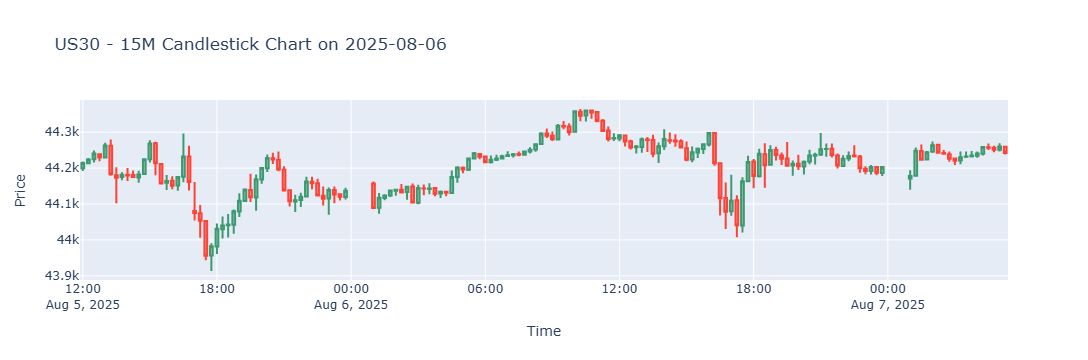

In [134]:
import plotly.graph_objects as go

if df.empty:
    print("No data found for the selected day.")
else:
    fig = go.Figure(data=[
        go.Candlestick(
            x=df.index,
            open=df['open'],
            high=df['high'],
            low=df['low'],
            close=df['close']
        )
    ])

    fig.update_layout(
        title=f"{symbol} - 15M Candlestick Chart on {date_str}",
        xaxis_title="Time",
        yaxis_title="Price",
        xaxis_rangeslider_visible=False
    )

    fig.show()
